# Tutorial: Creating Custom Aggregates with DynamicEventAggregator
This tutorial will guide you through using the `DynamicEventAggregator` to generate standard and custom event aggregates from match data.

## 📋 Prerequisites
- Python installed
- Access to the `skillcorner_analysis_lib` library
- Required libraries: `numpy`, `pandas`
```bash
pip install numpy pandas skillcorner
```

In [1]:
from platform import python_branch

import numpy as np
import pandas as pd
from io import BytesIO
from PhasesOfPlayAggregator import PhasesOfPlayAggregator
from skillcorner.client import SkillcornerClient

/Users/nano/PycharmProjects/opendata/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## ⚽ Step 2: Load Match Data
We will use the local filed to load dynamic event data for a specific match, but you can switch to your credentials

In [2]:
match_id = 1886347

# Instantiate the SkillCorner client
username = "your_username"
password = "your_password"
client = SkillcornerClient(username=username, password=password)

# Load dynamic event data from SkillCorner API
# events_df = pd.read_csv(BytesIO(client.get_dynamic_events(MATCH_ID)))

# Load dynamic event data from Open Source
phases_df = pd.read_csv(
    f"../../../data/matches/{match_id}/{match_id}_phases_of_play.csv"
)

## ➕ Step 3: Generate Standard Aggregates
Create an instance of `DynamicEventAggregator` and generate predefined aggregates like off-ball runs, line-breaking passes, and defensive engagements.

In [3]:
# Initialize the aggregator
phases_aggregator = PhasesOfPlayAggregator(phases_of_play_df=phases_df)

# Off-ball runs
in_possession_aggregates = phases_aggregator.get_in_possession_aggregates()
in_possession_aggregates.rename(columns={'team_in_possession_id':'team_id',
                                         'team_in_possession_shortname':'team_name'
                                         },
                                inplace=True
                                )
out_of_possession_aggregates = phases_aggregator.get_out_of_possession_aggregates()
out_of_possession_aggregates.rename(columns={'team_out_of_possession_id':'team_id',
                                         'team_out_of_possession_shortname':'team_name'
                                         },
                                inplace=True
                                )
phases_of_play_aggregates_all=in_possession_aggregates.merge(out_of_possession_aggregates,
                                                             on=['match_id','team_id','team_name'],
                                                             suffixes=('_ip','_oop'))
phases_of_play_aggregates_all.head()


,match_id,team_id,team_name,count_build_up,total_time_build_up,count_player_possessions_build_up,count_possession_lost_in_phase_build_up,count_possession_lead_to_shot_build_up,count_possession_lead_to_goal_build_up,avg_start_width_build_up,...,count_into_transition_from_defending_set_play,count_into_quick_break_from_defending_set_play,count_into_direct_from_defending_set_play,count_into_chaotic_from_defending_set_play,count_into_low_block_from_defending_set_play,count_into_medium_block_from_defending_set_play,count_into_high_block_from_defending_set_play,count_into_defending_quick_break_from_defending_set_play,count_into_defending_transition_from_defending_set_play,count_into_defending_direct_from_defending_set_play
0,1886347,1805,Newcastle,39.0,353.7,129.0,4.0,3.0,0.0,41.585556,...,NaN,NaN,NaN,2.0,2.0,3.0,NaN,NaN,NaN,NaN
1,1886347,4177,Auckland FC,24.0,219.0,72.0,3.0,3.0,0.0,45.182083,...,NaN,NaN,NaN,1.0,1.0,2.0,NaN,NaN,NaN,NaN


We now have a master dataframe per team per game with all the key aggregates for phases, namely
* Counts (Overall and outcomes)
* Durations

## 🛠️ Step 4: Calculate percentage of time spent
You can now easily calculate the total time spent in each phase


In [4]:
# This gives you the list of available time columns from the aggregates
time_columns=[i for i in phases_of_play_aggregates_all.columns.tolist() if 'time' in i]
time_columns

['total_time_build_up',
 'total_time_create',
 'total_time_finish',
 'total_time_transition',
 'total_time_quick_break',
 'total_time_direct',
 'total_time_chaotic_ip',
 'total_time_set_play',
 'total_time_low_block',
 'total_time_medium_block',
 'total_time_high_block',
 'total_time_defending_transition',
 'total_time_defending_quick_break',
 'total_time_defending_direct',
 'total_time_chaotic_oop',
 'total_time_defending_set_play']

In [5]:
phases_of_play_aggregates_duration=phases_of_play_aggregates_all[['match_id','team_id','team_name']+time_columns]

for time_col in time_columns:
    phases_of_play_aggregates_duration[time_col+'_pct']=phases_of_play_aggregates_duration[time_col]*100/phases_of_play_aggregates_duration[time_columns].sum(axis=1)

phases_of_play_aggregates_duration

/var/folders/vg/hbdnhqg500z2njwry3wyth400000gn/T/ipykernel_81994/2350198538.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phases_of_play_aggregates_duration[time_col+'_pct']=phases_of_play_aggregates_duration[time_col]*100/phases_of_play_aggregates_duration[time_columns].sum(axis=1)
/var/folders/vg/hbdnhqg500z2njwry3wyth400000gn/T/ipykernel_81994/2350198538.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phases_of_play_aggregates_duration[time_col+'_pct']=phases_of_play_aggregates_duration[time_co

,match_id,team_id,team_name,total_time_build_up,total_time_create,total_time_finish,total_time_transition,total_time_quick_break,total_time_direct,total_time_chaotic_ip,...,total_time_chaotic_ip_pct,total_time_set_play_pct,total_time_low_block_pct,total_time_medium_block_pct,total_time_high_block_pct,total_time_defending_transition_pct,total_time_defending_quick_break_pct,total_time_defending_direct_pct,total_time_chaotic_oop_pct,total_time_defending_set_play_pct
0,1886347,1805,Newcastle,353.7,646.9,150.1,NaN,NaN,36.2,166.7,...,5.245437,1.198867,15.053493,21.576463,6.891126,1.378225,0.704846,1.164254,4.660164,4.779736
1,1886347,4177,Auckland FC,219.0,685.7,478.4,43.8,22.4,37.0,148.1,...,4.660164,4.779736,4.723096,20.355570,11.129641,NaN,NaN,1.139081,5.245437,1.198867


## 📊Step 5: Visualization time
Now Simply use our head2head_viz function to compare 2 teams


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


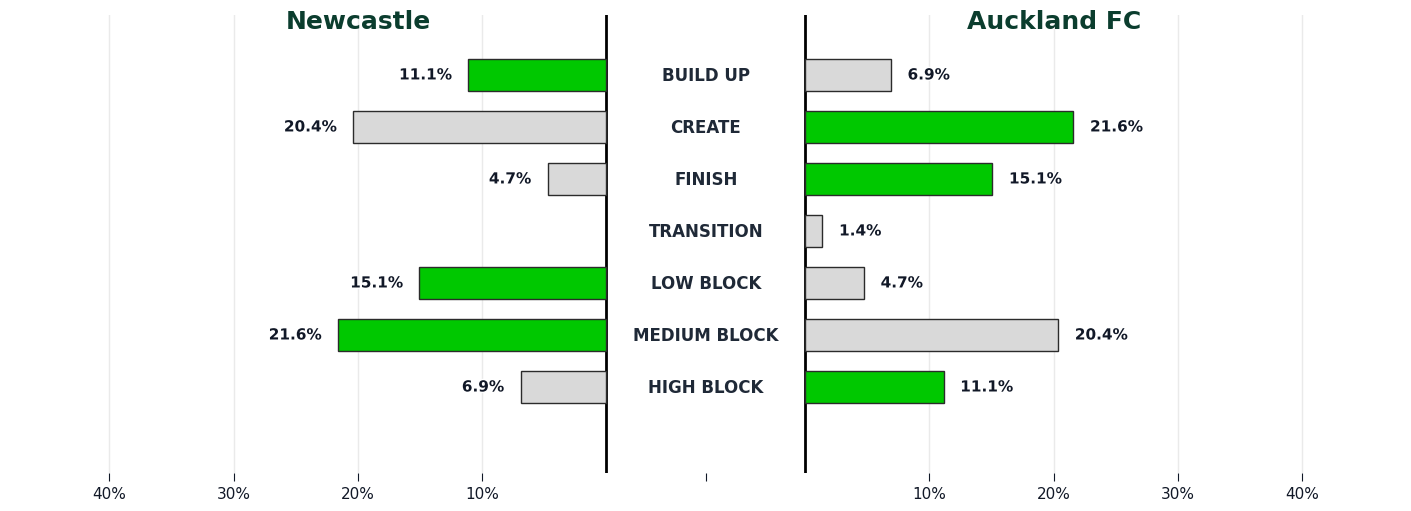

In [6]:
from head2head_viz import plot_head2head

metrics_of_interest={'total_time_build_up_pct':'BUILD UP',
 'total_time_create_pct':'CREATE',
 'total_time_finish_pct':'FINISH',
'total_time_transition_pct':'TRANSITION',
'total_time_low_block_pct':'LOW BLOCK',
'total_time_medium_block_pct':'MEDIUM BLOCK',
'total_time_high_block_pct':'HIGH BLOCK'
                     }


fig,ax=plot_head2head(phases_of_play_aggregates_duration,
                               category_column='team_name',
                               metrics=metrics_of_interest.keys(),
                               metric_labels=metrics_of_interest,
                      unit='%',
                      xaxis='auto')


fig.savefig('test.png',dpi=300,format='png',transparent=False)

